In [2]:
import torch
from torch_geometric.data import Data, DataLoader
import pandas as pd
import numpy as np
import config as cfg

In [57]:
graphs = []

feature_lv = ["CMR_LV_mass","CMR_LV_EDV", "CMR_LV_ESV", "CMR_EF",
"CMR_max_ED_thickness_ineferolat_wall","CMR_max_ES_thickness_ineferolat_wall","LA_Volume",
"LVEDD","LVESD","LVPWd","IVSs"]

def load_patient_data(clinical_datapath):
    patientdata = pd.read_excel(clinical_datapath).drop([0,1])
    patientdata["Pat_no"] = patientdata["Pat_no"].astype(int)
    patientdata = patientdata.set_index("Pat_no")
    return patientdata

df = load_patient_data(cfg.CLINICAL_DATA_XL)
any_arrhythmia = df[["Aborted_cardiac_arrest",
                               "Ventricular_tachycardia",
                               "nsVT"]].fillna(0).sum(axis = 1) > 0


df["any_arrhythmia"] = any_arrhythmia
for index, row in df.iterrows():
    # Assuming each feature becomes a node
    # Create node features (x) from the row data
    x   = torch.tensor([[row[feature]] for feature in feature_lv], dtype=torch.float).transpose(0,-1)
    y = torch.tensor([row["any_arrhythmia"]], dtype=torch.float).transpose(0,-1)
    x = torch.nan_to_num(x, nan=0.0)
    y = torch.nan_to_num(y, nan=0.0)

    # Define edge_index based on your graph structure
    # For a fully-connected graph:
    edge_index = torch.combinations(torch.arange(x.size(0)), r=2, with_replacement=False).t().contiguous()

    # Create a graph for each patient
    graph = Data(x=x, edge_index=edge_index,y=y)
    graphs.append(graph)
loader = DataLoader(graphs, batch_size=1, shuffle=True)


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import pdb
import matplotlib.pyplot as plt
class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GraphAutoencoder, self).__init__()

        # Encoder layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)

        # Decoder layers
        self.deconv1 = GCNConv(latent_dim, hidden_dim)
        self.deconv2 = GCNConv(hidden_dim, input_dim)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        z = (self.conv2(x, edge_index))
        
        return z

    def decode(self, z, edge_index):
        z = F.relu(self.deconv1(z, edge_index))
        xHat = self.deconv2(z, edge_index)
        return xHat

    def forward(self, x, edge_index):
        z = self.encode( x, edge_index)# obtain latent representations from encoder
        x_hat = self.decode(z, edge_index)# obtain reconstructed node features from decoder
        return x_hat, z

In [66]:
# Example usage
input_dim = 11  # Input node feature dimension
hidden_dim = 64  # Hidden layer dimension
latent_dim = 5  # Latent space dimension

num_epochs = 100


model = GraphAutoencoder(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(num_epochs):
    for data in loader:
        # print(data)
        x, edge_index,y = data.x, data.edge_index,data.y

        optimizer.zero_grad()
        x_hat, z = model(x, edge_index)
        # print(x_hat,y)
        loss = F.mse_loss(x_hat, y)  # Mean Squared Error loss
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

/var/folders/yw/xswvqj2x1ldf3fv5s9nl66z40000gn/T/ipykernel_71697/4241594232.py:21: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x_hat, y)  # Mean Squared Error loss


Epoch 1, Loss: 0.3017800450325012
Epoch 2, Loss: 1.055144190788269
Epoch 3, Loss: 0.10450123995542526
Epoch 4, Loss: 0.16500194370746613
Epoch 5, Loss: 0.4400861859321594
Epoch 6, Loss: 0.392525315284729
Epoch 7, Loss: 0.1466899961233139
Epoch 8, Loss: 0.7222296595573425
Epoch 9, Loss: 0.016553916037082672
Epoch 10, Loss: 0.061235856264829636
Epoch 11, Loss: 0.9056932926177979
Epoch 12, Loss: 0.13389863073825836
Epoch 13, Loss: 0.6261287331581116
Epoch 14, Loss: 0.09131024032831192
Epoch 15, Loss: 0.08315230160951614
Epoch 16, Loss: 0.07816977053880692
Epoch 17, Loss: 0.08510753512382507
Epoch 18, Loss: 0.22427693009376526
Epoch 19, Loss: 0.4958960711956024
Epoch 20, Loss: 0.00041241434519179165
Epoch 21, Loss: 0.28840959072113037
Epoch 22, Loss: 0.3816298246383667
Epoch 23, Loss: 0.044813524931669235
Epoch 24, Loss: 0.006423753686249256
Epoch 25, Loss: 0.13459435105323792
Epoch 26, Loss: 0.14780038595199585
Epoch 27, Loss: 0.7948219776153564
Epoch 28, Loss: 0.2671627700328827
Epoch 29

In [67]:
# Low dimensional features using learnt features
embeddings = []
B = 1

with torch.no_grad():
    for data in loader:
            x, edge_index = data.x, data.edge_index
            _, z = model(x, edge_index)
            embeddings.append(z.mean(0))
embeddings = torch.stack(embeddings)

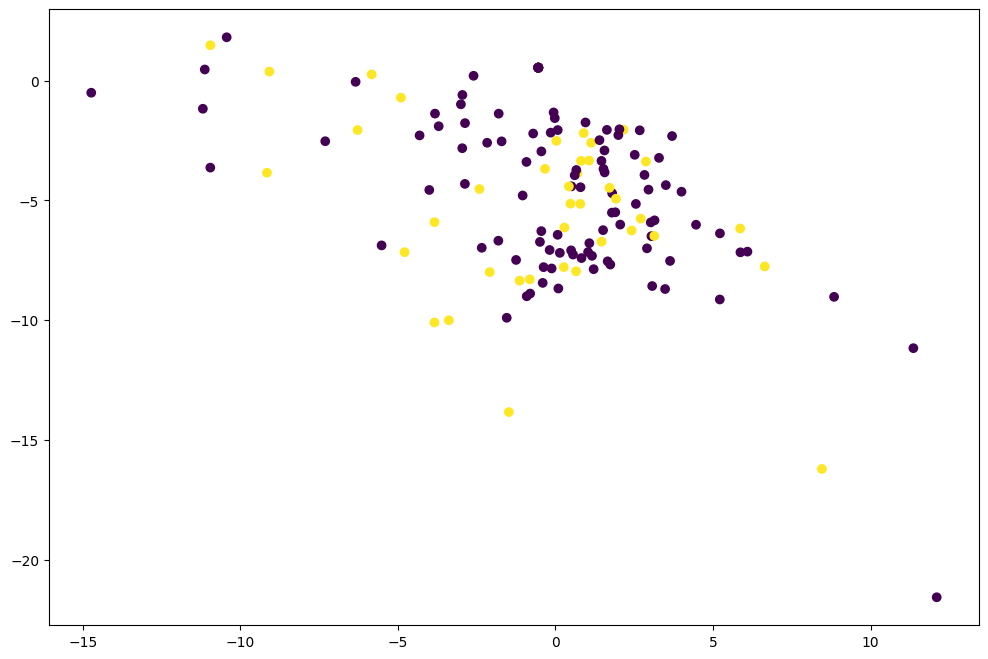

In [68]:
labels = [t.y for t in loader] #
plt.figure(figsize=(12,8))
plt.scatter(embeddings[:,0],embeddings[:,1],c=labels)

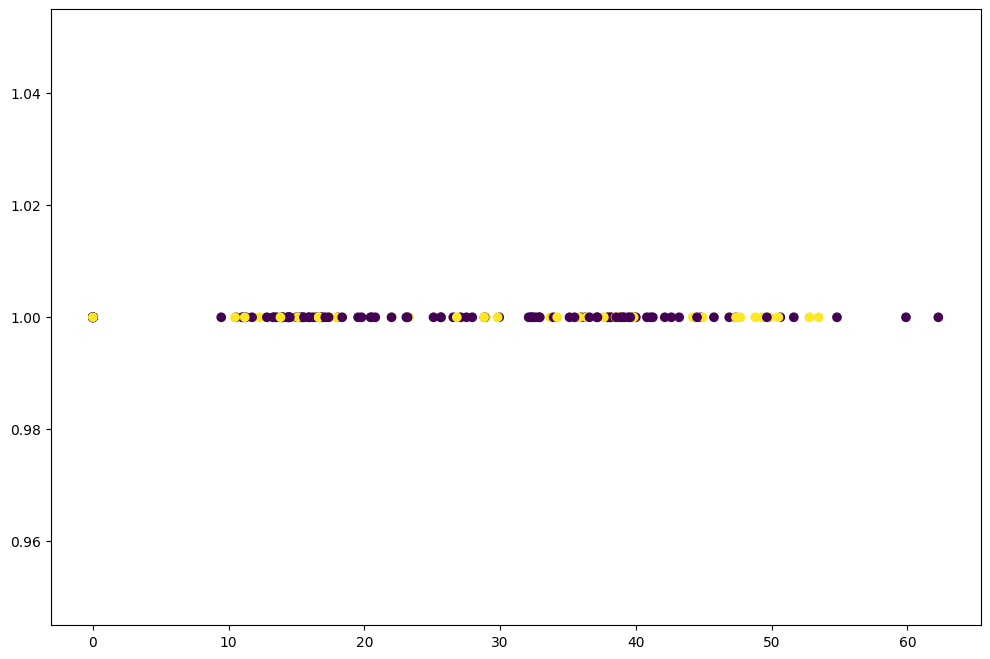

In [62]:
# Low dimensions using handcrafted features
feature_1 = [t.x.mean() for t in loader] #
feature_2 = [t.x.shape[0] for t in loader]#
labels = [t.y for t in loader] #
plt.figure(figsize=(12,8))
plt.scatter(feature_1,feature_2,c=labels)